In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [8]:
# Load thedata into a Pandas DataFrame.
data = pd.read_csv("HistoricalPrices-3.csv")

# Normalize the data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data.iloc[:, 4].values.reshape(-1, 1))

# Split the data into training and testing sets
train_data_normalized, test_data_normalized = train_test_split(data_normalized, test_size=0.2, shuffle=False)

In [9]:
# Define the state function
def get_state(state_index, data):
    lookback_window = 5  # Number of previous time steps to consider
    start_index = max(0, state_index - lookback_window)
    end_index = state_index + 1
    state = data[start_index:end_index].flatten()
    return state

In [10]:
# Define the actions
num_actions = 2  # Buy (1) or Hold (0)
action_mapping = {0: 'Hold', 1: 'Buy'}

# Create a Q-table, which is a table that stores the Q-values for each state-action pair.
num_train_states = train_data_normalized.shape[0]
num_test_states = test_data_normalized.shape[0]
q_table = torch.zeros((num_train_states, num_actions))
# Initialize the Q-table with random values.
nn.init.xavier_uniform_(q_table)

tensor([[-0.0456,  0.0349],
        [ 0.0525, -0.0298],
        [ 0.0288,  0.0558],
        ...,
        [-0.0135, -0.0361],
        [-0.0093, -0.0067],
        [-0.0085,  0.0380]])

In [11]:
# Define the epsilon-greedy policy
def epsilon_greedy_policy(state, q_table, epsilon):
    if random.random() < epsilon:
        action = random.randint(0, num_actions - 1)
    else:
        action = torch.argmax(q_table[state])
    return action

In [12]:
# Define the Bellman equation
def bellman_equation(state, action, reward, next_state_index, q_table):
    if next_state_index < num_train_states:
        next_state = torch.tensor([next_state_index])
        target = reward + gamma * torch.max(q_table[next_state])
    else:
        target = reward
    q_table[state, action] = target

In [13]:
# Training phase
num_epochs = 30
epsilon = 1.0
gamma = 0.98
replay_buffer = []
batch_size = 32
target_update_freq = 10
target_q_table = q_table.clone()

for i in range(num_epochs):
    for state in range(num_train_states - 1):
        current_state = get_state(state, train_data_normalized)
        action = epsilon_greedy_policy(state, q_table, epsilon)
        reward = train_data_normalized[state + 1].item()  # Convert tensor to a Python scalar
        next_state_index = state + 1
        bellman_equation(state, action, reward, next_state_index, q_table)

        # Store experience in replay buffer
        replay_buffer.append((current_state, action, reward, next_state_index))

        # Perform experience replay
        if len(replay_buffer) >= batch_size:
            batch = random.sample(replay_buffer, batch_size)
            for batch_current_state, batch_action, batch_reward, batch_next_state_index in batch:
                bellman_equation(batch_current_state, batch_action, batch_reward, batch_next_state_index, q_table)

    # Update target Q-table
    if i % target_update_freq == 0:
        target_q_table = q_table.clone()

    # Decay epsilon
    epsilon *= 0.70

In [14]:
# Testing phase
shares = 0
portfolio = 10000
profits = []
returns = []
risks = []
for state in range(num_test_states - 1):
    current_state = get_state(state, test_data_normalized)
    action = torch.argmax(q_table[state])
    if action == 1:
        shares += 1
    profit = scaler.inverse_transform([test_data_normalized[state + 1]]) * shares - portfolio
    price_ratio = scaler.inverse_transform(test_data_normalized[state + 1].reshape(1, -1)) / scaler.inverse_transform(test_data_normalized[state].reshape(1, -1))
    return_on_investment = (price_ratio * shares)
    risk = ((return_on_investment - portfolio) / portfolio)  # Risk as a ratio of the initial portfolio
    profits.append(profit)
    returns.append(price_ratio)
    risks.append(risk)
    
# Flatten the profits list
flattened_profits = [item for sublist in profits for item in sublist]

In [15]:
# Calculate average return, total return, average risk, and total risk
avg_return = float(sum(returns)) / len(returns)
total_return = float(profits[-1])  # Total return is the final profit
avg_risk = float(sum([abs(r) for r in risks])) / len(risks)  # Average of absolute risks
total_risk = float(sum([abs(r) for r in risks]))  # Total risk is the sum of absolute risks

# Print the calculated values
print(f"Average Return: {avg_return:.4f}")
print(f"Total Return: {total_return:.4f}")
print(f"Average Risk: {avg_risk:.4f}")
print(f"Total Risk: {total_risk:.4f}")

Average Return: 1.0001
Total Return: 1233015.1000
Average Risk: 0.9880
Total Risk: 459.4365


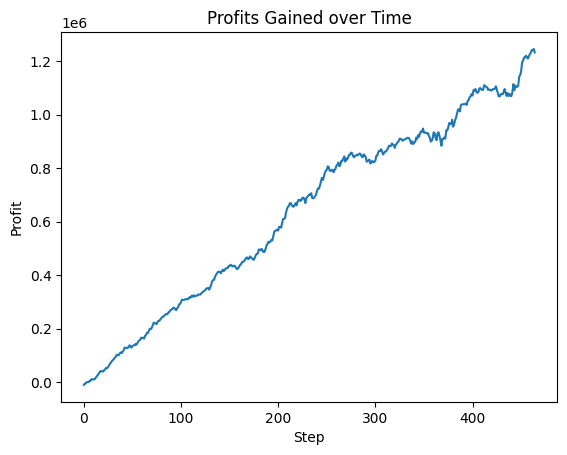

In [16]:
# Visualize the results
plt.plot(flattened_profits)
plt.xlabel('Step')
plt.ylabel('Profit')
plt.title('Profits Gained over Time')
plt.show()